# Designing the quantum walk operator for the case of a line with 16 nodes

##  Quantum Walk?

A quantum (random) walk is the quantum counterpart of a classical random walk, where the walker follows a probabilistic path. Quantum random walks can outperform classical random walks in certain computational task.

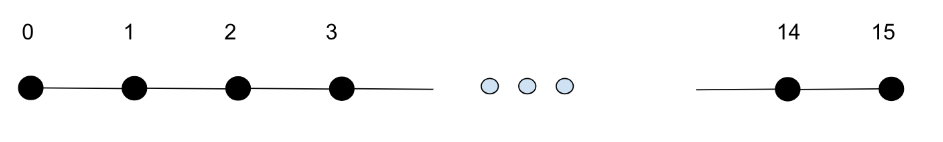

_Image credits: Womanium Quantum + AI Scholarip Program with Classiq on Canva_

In [10]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences

In [11]:
size = 4 #log2(16)=4
num_nodes = 16 # 2**4=16

For the alogrtihm implementation there are two main steps:
1) C operator: Traverse the graph based on given probabilities
2) s Operato: to simulate the actual movement

## C Operator
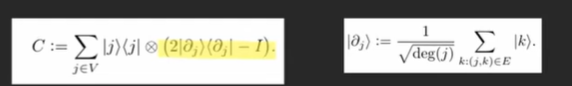

Image from: Bootcamp 4 lecture( Anrew Childs notes)

The C operator is concerned with following the path with the given probabs. We use diffuser oracle to to amplify the probabilities of adjacent nodes, because it is between them the movement occurs

In [12]:
# Function to prepare a qubit in the |-> state
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):

    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

def C_iter(i:int,vertices: QNum, adjacent_vertices:QNum):# Defines the C operation for the walk
    prob = [0]*num_nodes  
    if i == 0:
        prob[i + 1] = 1.0  # If at the first node,then given hat it a is a straight line traversal,it can only move to the right(i+1), with probability 1
    elif i == num_nodes - 1:
        prob[i - 1] = 1.0 #If at the last node, then we can only move back to the second last node with probab 1.
    else: #On the other nodes, between 0 nad 15, we can move either forward and backward with equal probability, thT IS 0.5. tHERE IS NOR ESTRICTION N EITHER MOVEMNT
        prob[i - 1] = 0.5  
        prob[i + 1] = 0.5  
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))
# The below function defines the C operator fucntion.
@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(num_nodes):
        C_iter(i,vertices,adjacent_vertices)

## S Operator(Shift)
Given by:

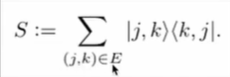

Credits: Bootcamp 4 lecture(Andrew Childs's notes)

This operation is concerned with actual movemnt of the particle. What makes this important, is that here quantum effects can take palce, which can affect the probab amplitudes of different paths.



In [13]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1)) #This makes sure the movement is between two adjacent vertices only

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]): #This fn swaps the current state with the next state.
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

## Main Function

In [14]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size, vertices)  # Allocate vertix qubits 
    hadamard_transform(vertices)  # Hadmard to create the initial superpositon of the 16 states
    allocate(size, adjacent_vertices) 
    
    C_operator(vertices, adjacent_vertices)  
    S_operator(vertices, adjacent_vertices) 

# Circuit

In [15]:

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

As we can see the prob vec of at each node has probs as we defiend in the start. Unless the nodes is first or last, the particle can move with probab 0.5 in either direction. If at first node, the prob vec moves shows that we can only move to the right, and if at last , then only to the left.

The circuit implmented is:

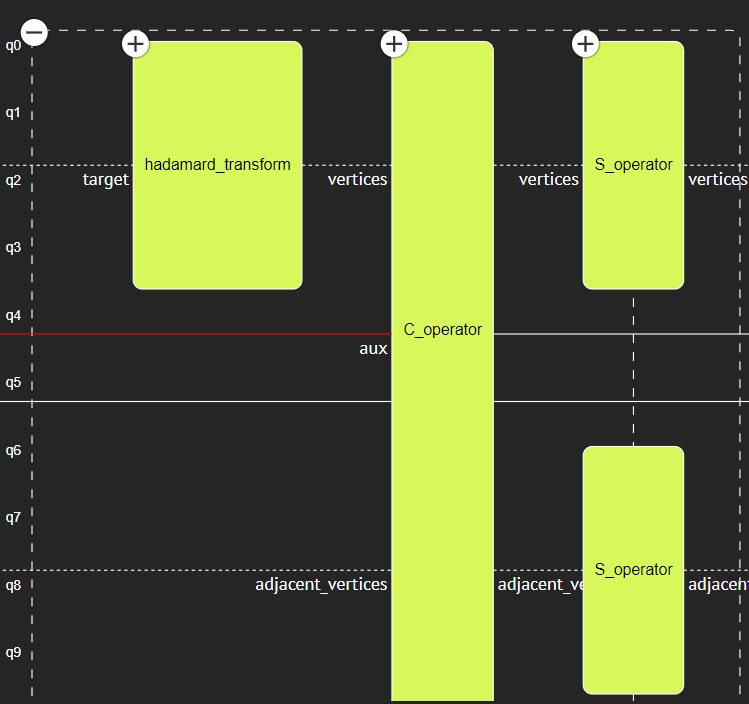

Width and Depth details:
Depth: 3157
Width: 37

The Hadamard is first applied to the first 4 qubits to create a superpositin of the 16 states.

This is followed by the C and S operators.

In depth C:

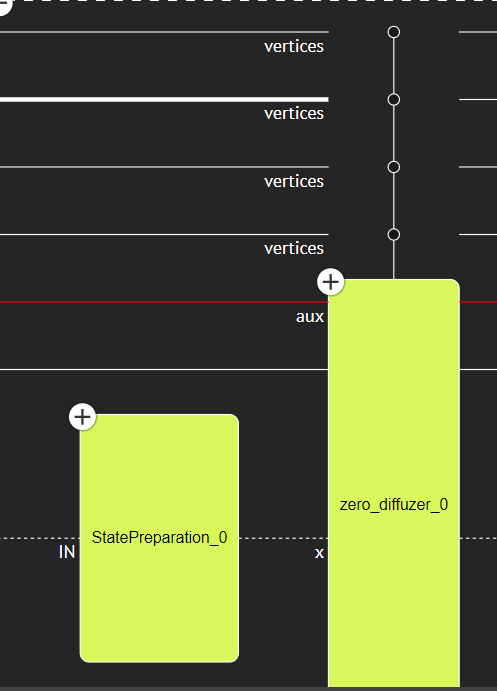

As we can see that the state prep operator is followed by the diffusors

In depth S:

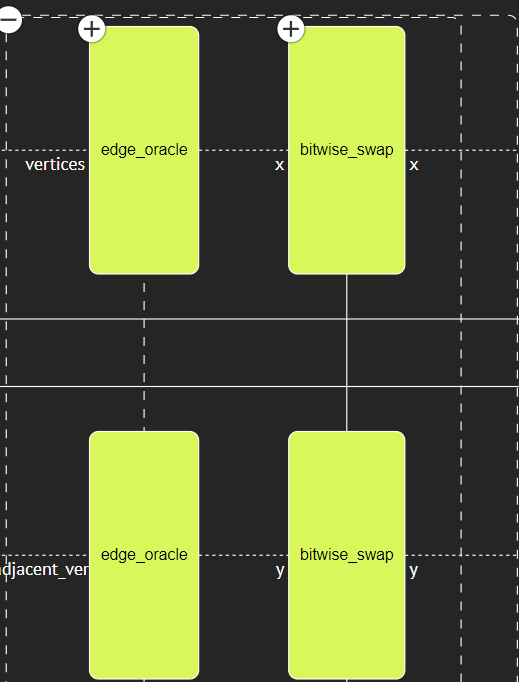

The edge-check operation(to determine the edges are indeed adjacent) is followed by the swaping of states.